# Chapter 4: Tactical portfolio management

### 4.1. How dynamic methods works?
> ###### 4.1.1. Short a stock
> ###### 4.1.2. Momentum factor
> ###### 4.1.3. Rebalancing

### 4.2. Moving average strategy
> ###### 4.2.1. Moving average 
> ###### 4.2.2. Moving average factor
> ###### 4.2.3. Build the strategy

### 4.3. Correlation strategy
> ###### 4.3.1. Correlation
> ###### 4.3.2. Correlation factor
> ###### 4.3.3. Build the strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importation of data
list_tickers = ["FB", "NFLX", "TSLA"]
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

[*********************100%***********************]  3 of 3 completed


### 4.2.1. Moving average

In [3]:
# Create the SMA15 for the stocks
data["SMA15 FB"] = data["FB"].rolling(15).mean().shift(1)
data["SMA15 NFLX"] = data["NFLX"].rolling(15).mean().shift(1)
data["SMA15 TSLA"] = data["TSLA"].rolling(15).mean().shift(1)

# Create a SMA60
data["SMA60 FB"] = data["FB"].rolling(60).mean().shift(1)

# Plot the data
print(data)

                    FB        NFLX        TSLA    SMA15 FB  SMA15 NFLX  \
Date                                                                     
2012-05-18   38.230000    9.994286    5.512000         NaN         NaN   
2012-05-21   34.029999   10.248571    5.754000         NaN         NaN   
2012-05-22   31.000000    9.672857    6.160000         NaN         NaN   
2012-05-23   32.000000   10.272857    6.204000         NaN         NaN   
2012-05-24   33.029999   10.038571    6.056000         NaN         NaN   
...                ...         ...         ...         ...         ...   
2021-09-14  376.529999  577.760010  744.489990  374.722670  577.212663   
2021-09-15  373.920013  582.869995  755.830017  375.601337  578.841329   
2021-09-16  373.059998  586.500000  756.989990  376.162004  580.805330   
2021-09-17  364.720001  589.349976  759.489990  376.473336  583.399996   
2021-09-20  355.700012  575.429993  730.169983  376.496002  586.015328   

            SMA15 TSLA    SMA60 FB  


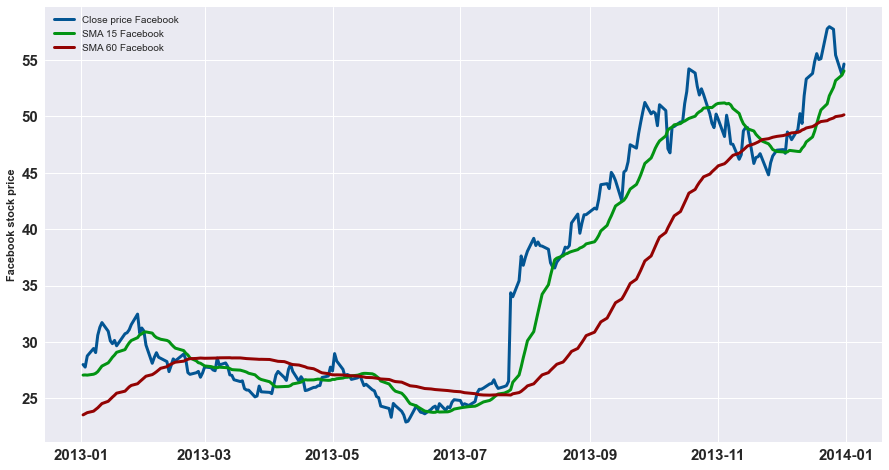

In [4]:
# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(data["FB"].loc["2013"], color="#035593", linewidth=3)
plt.plot(data["SMA15 FB"].loc["2013"], color="#039313", linewidth=3)
plt.plot(data["SMA60 FB"].loc["2013"], color="#930303", linewidth=3)
plt.ylabel("Facebook stock price",fontweight="bold")
plt.legend(["Close price Facebook", "SMA 15 Facebook", "SMA 60 Facebook"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

<br>

### 4.2.2. Moving average factor

###### From this point the data are monthly and not daily

In [5]:
# We need monthly data now

# Importation of data
list_tickers = ["FB", "NFLX", "TSLA"]
database = yf.download(list_tickers, interval="1mo")

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

# Display the data
data

[*********************100%***********************]  3 of 3 completed


,FB,NFLX,TSLA
Date,,,
2012-06-01,31.100000,9.784286,6.258000
2012-07-01,21.709999,8.121429,5.484000
2012-08-01,18.059999,8.531429,5.704000
2012-09-01,21.660000,7.777143,5.856000
2012-10-01,21.110001,11.320000,5.626000
...,...,...,...
2021-06-01,347.709991,528.210022,679.700012
2021-07-01,356.299988,517.570007,687.200012
2021-08-01,379.380005,569.190002,735.719971


In [6]:
# Create the all necessary SMA
list_tickers = ["FB", "NFLX", "TSLA"]

# We do a loop to create the SMAs for each asset
for col in list_tickers:
    data[f"pct {col}"] = data[col].pct_change(1)
    data[f"SMA3 {col}"] = data[col].rolling(3).mean().shift(1)
    data[f"SMA12 {col}"] = data[col].rolling(12).mean().shift(1)
    data[f"Momentum factor {col}"] = data[f"SMA3 {col}"] - data[f"SMA12 {col}"]

# Normalizing the zscore
split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]

# Find the mean and std vectors
columns = [f"Momentum factor {col}" for col in list_tickers]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

# Create the zscores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std

# Find the medians
median = train_set[columns].median()

<br>

### 4.2.3. Build the strategy

In [7]:
# Compute the signals and the profits
for i in range(len(columns)):

    # Initialize a new column for the signal
    test_set[f"signal {columns[i]}"] = 0

    # Signal is -1 if factor < median
    test_set.loc[test_set[f"{columns[i]}"]<median[i], 
               f"signal {columns[i]}"] = -1

    # Signal is 1 if factor > median
    test_set.loc[test_set[f"{columns[i]}"]>median[i], 
               f"signal {columns[i]}"] = 1


    # Compute the profit
    test_set[f"profit {columns[i]}"] = (test_set[f"signal {columns[i]}"]\
          .shift(1)) * test_set[f"pct {list_tickers[i]}"]

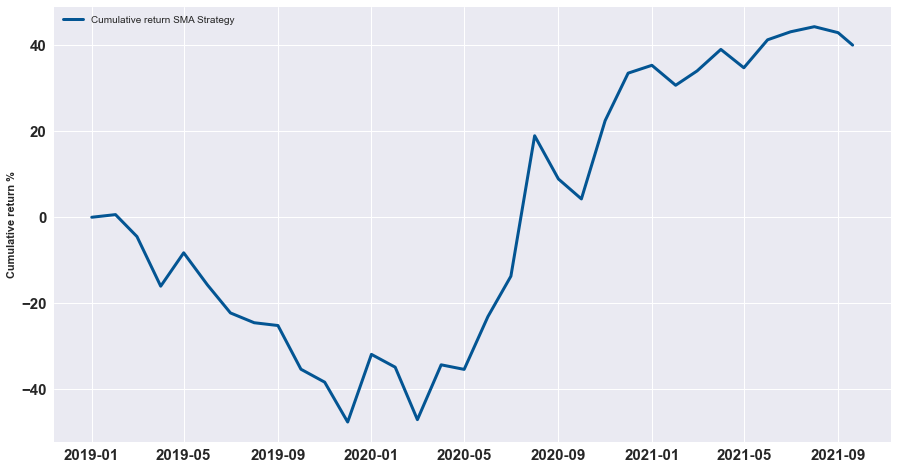

In [8]:
returns = test_set[[f"profit {columns[i]}" \
        for i in range(len(columns))]].sum(axis=1) .cumsum()*100/3

plt.figure(figsize=(15,8))
plt.plot(returns, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.legend(["Cumulative return SMA Strategy"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.942 	 Alpha: 4.39 %	     Sharpe: 0.423 	 Sortino: 1.095
  -----------------------------------------------------------------------------
    VaR: 63.76 %	 cVaR: 74.8 % 	     VaR/cVaR: 1.173 	 drawdown: 40.82 %
  -----------------------------------------------------------------------------


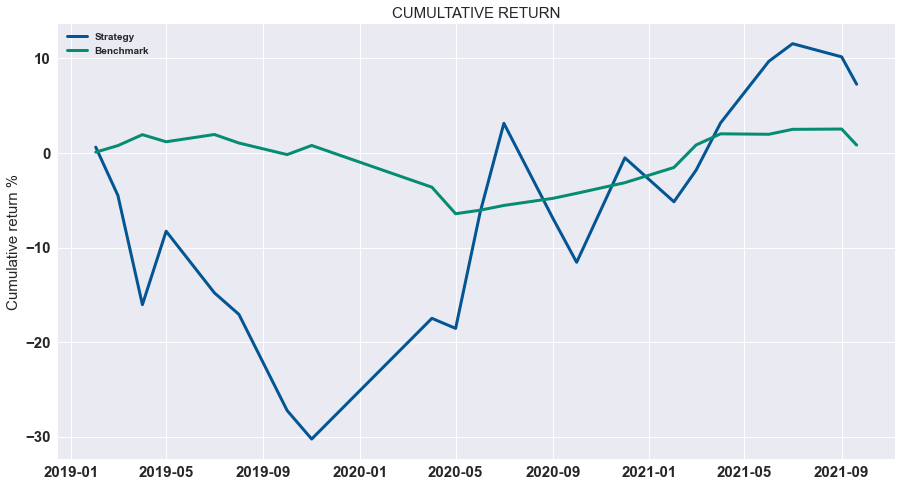

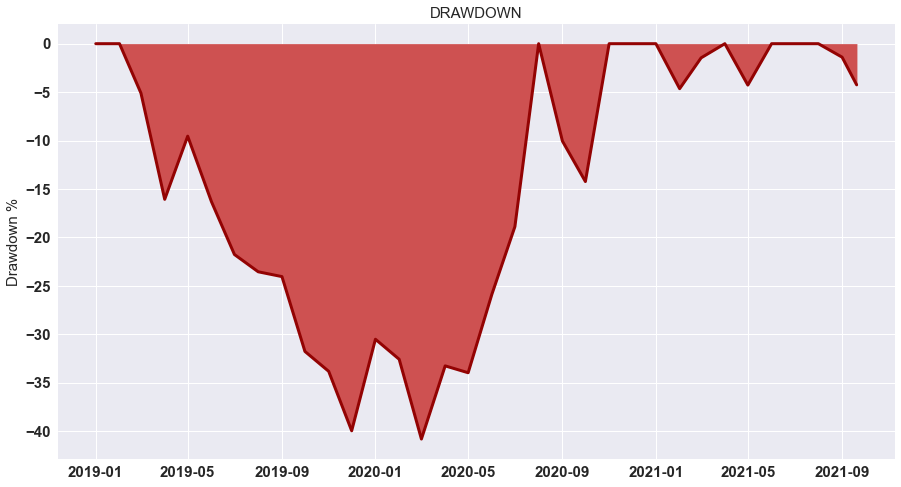

In [12]:
# Code created in the chapter 5
from Backtest import *
pi = (test_set[[f"profit {columns[i]}" for i in range(len(columns))]].sum(axis=1)/3)
backtest_dynamic_portfolio(pi, timeframe=12)

<br>
<br>
<br>



### 4.3.1. Correlation

In [13]:
# Plot absolute price correlation
data[list_tickers].corr()

,FB,NFLX,TSLA
FB,1.000000,0.946590,0.814121
NFLX,0.946590,1.000000,0.778214
TSLA,0.814121,0.778214,1.000000


In [14]:
# Plot returns correlation
data[list_tickers].pct_change(1).corr()

,FB,NFLX,TSLA
FB,1.000000,0.31401,0.296253
NFLX,0.314010,1.00000,0.193080
TSLA,0.296253,0.19308,1.000000


<br>

### 4.3.2. Trend return factor

In [15]:
# Our stocks list
list_ = ["TSLA", "GOOG", "FB", "NVDA", "PYPL", "CMCSA", "INTC", "NFLX"] 

In [16]:
# We need monthly data now

# Importation of data
database = yf.download(list_, interval="1mo")

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna()

#Display the data
data

[*********************100%***********************]  8 of 8 completed


,CMCSA,FB,GOOG,INTC,NFLX,NVDA,PYPL,TSLA
Date,,,,,,,,
2015-08-01,25.112804,89.430000,618.250000,24.117027,115.029999,5.451025,35.000000,49.812000
2015-09-01,25.358006,89.900002,608.419983,25.680649,103.260002,6.002364,31.040001,49.680000
2015-10-01,27.916985,101.970001,710.809998,28.850260,108.379997,6.908196,36.009998,41.386002
2015-11-01,27.248365,104.239998,742.599976,29.625622,123.330002,7.723935,35.259998,46.051998
2015-12-01,25.264954,104.660004,758.880005,29.559734,114.379997,8.056355,36.200001,48.001999
...,...,...,...,...,...,...,...,...
2021-06-01,56.775990,347.709991,2506.320068,55.777538,528.210022,199.943909,291.480011,679.700012
2021-07-01,58.578247,356.299988,2704.419922,53.373165,517.570007,194.955627,275.529999,687.200012
2021-08-01,60.680000,379.380005,2909.239990,53.710968,569.190002,223.810532,288.660004,735.719971


In [17]:
# Compute the lookback and hold period
for col in list_:
    data[f"pct+1 {col}"] = data[f"{col}"].pct_change(-1)
    data[f"pct-12 {col}"] = data[f"{col}"].pct_change(12)

# Normalizing the zscore
split = int(0.7*len(data))
train_set = data.iloc[:split,:]
test_set = data.iloc[split:,:]


# Compute the correlation
corr = []
for col in list_:
    cor = train_set[[f"pct-12 {col}", f"pct+1 {col}"]].corr().values[0][1]

    corr.append(cor)

correlation = pd.DataFrame(corr, index=list_, columns=["Corr"])
correlation.sort_values(by="Corr", ascending=False)

,Corr
INTC,0.285859
GOOG,0.237296
TSLA,0.192293
PYPL,0.181100
CMCSA,0.151008
NFLX,0.084158
FB,0.083606
NVDA,-0.159689


<br>

### Build the strategy

In [18]:
best = ["PYPL", "INTC", "GOOG"]

# Find the mean and std vectors
columns = [f"pct-12 {col}" for col in best]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()

# Create the zscores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std

# Find the medians
median = train_set[columns].median()

# Compute the signals and the profits
for i in range(len(columns)):

    # Initialize a new column for the signal
    test_set[f"signal {columns[i]}"] = 0

    # Signal is -1 if factor < median
    test_set.loc[test_set[f"{columns[i]}"]<median[i], 
               f"signal {columns[i]}"] = -1

    # Signal is 1 if factor > median
    test_set.loc[test_set[f"{columns[i]}"]>median[i], 
               f"signal {columns[i]}"] = 1


    # Compute the profit
    test_set[f"profit {columns[i]}"] = (test_set[f"signal {columns[i]}"]\
          .shift(1)) * test_set[f"pct+1 {best[i]}"]

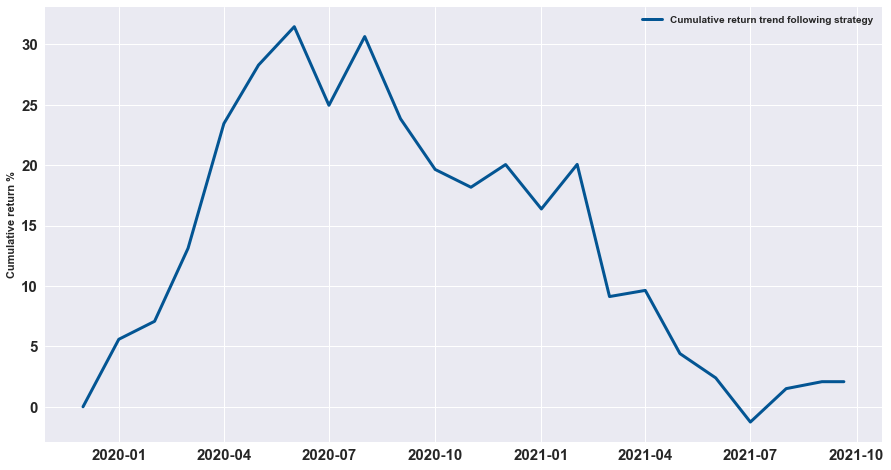

In [19]:
returns = test_set[[f"profit {columns[i]}" \
        for i in range(len(columns))]].sum(axis=1) .cumsum()*100/3

plt.figure(figsize=(15,8))
plt.plot(returns, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.legend(["Cumulative return trend following strategy"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -2.056 	 Alpha: -7.75 %	     Sharpe: 0.062 	 Sortino: 0.109
  -----------------------------------------------------------------------------
    VaR: 39.49 %	 cVaR: 45.57 % 	     VaR/cVaR: 1.154 	 drawdown: 29.17 %
  -----------------------------------------------------------------------------


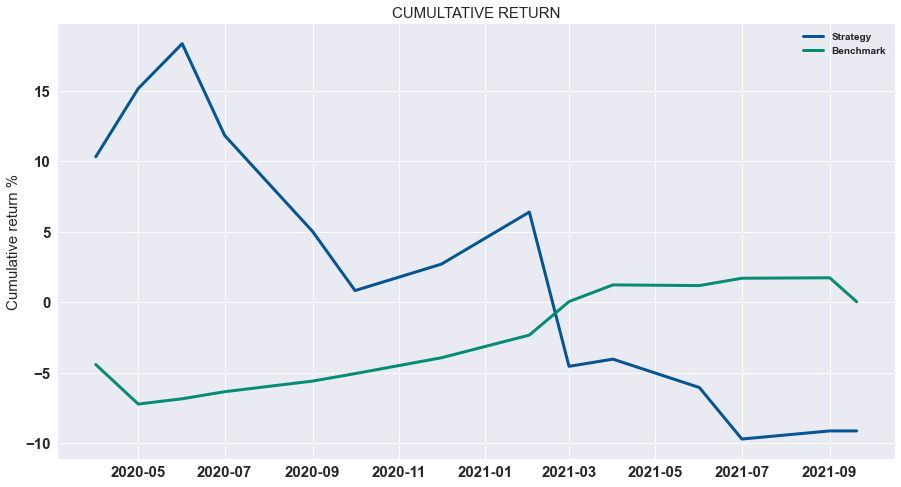

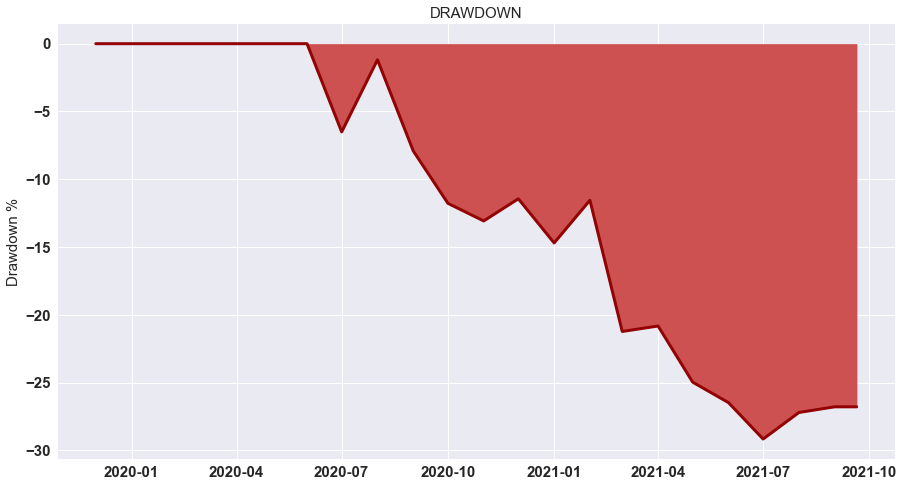

In [21]:
from Backtest import backtest_dynamic_portfolio
pi = (test_set[[f"profit {columns[i]}" for i in range(len(columns))]].sum(axis=1)/3)
backtest_dynamic_portfolio(pi, timeframe=12)